# VAE (Variational Autoencoders)

## 1. Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive/')  # mount your Google Drive to access datasets stored in your drive

Mounted at /content/drive/


In [2]:
!mkdir /content/drive/MyDrive/Colab\ Notebooks/data_3000  # create a folder for the uploaded data; you can change the file path if needed
!unzip -o /content/drive/MyDrive/Colab\ Notebooks/data_3000.zip -d /content/drive/MyDrive/Colab\ Notebooks/data_3000

Archive:  /content/drive/MyDrive/Colab Notebooks/data_3000.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/22.5651.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.119.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.149.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.2255.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.2919.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.3077.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.3701.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.388.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4496.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4706.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4709.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4904.jpg  
  inflating: /content/drive/

## 2. Import python libraries

In [3]:
import numpy as np  # library for numerical calculations
import pandas as pd  # data analysis library
import cv2 as cv  # computer vision library for image processing
import matplotlib.pyplot as plt  # visualization library for charts and plots
import os  # operating system library for file handling

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # model optimization
from torch.utils.data import DataLoader, TensorDataset  # dataset management
from torchsummary import summary  # model summary

import scipy.io
from sklearn.manifold import TSNE  # dimensionality reduction based on latent space t-SNE
from sklearn.model_selection import train_test_split  # split data into training and testing sets

print(torch.__version__)      # check pytorch version

2.4.0+cu121


## 3. Convert images into trainable data & Split dataset

In [4]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = '/content/drive/MyDrive/Colab Notebooks/data_3000/'

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))

# split the data into 80% training set and 20% test set (test set can be considered as validation)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


# reshape the (image,image) images into (image*image,) size vectors
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## 4. Set model hyperparameters

In [5]:
# model architecture parameters
input_dim = x_train.shape[1]  # flattened image size (56*56 = 3136)
intermediate_dim = 512  # hidden layer dimension
latent_dim = 2  # latent space dimension (z-dim)

# training parameters
num_epochs = 100
batch_size = 20
learning_rate = 1e-3

## 5. Set to model architecture

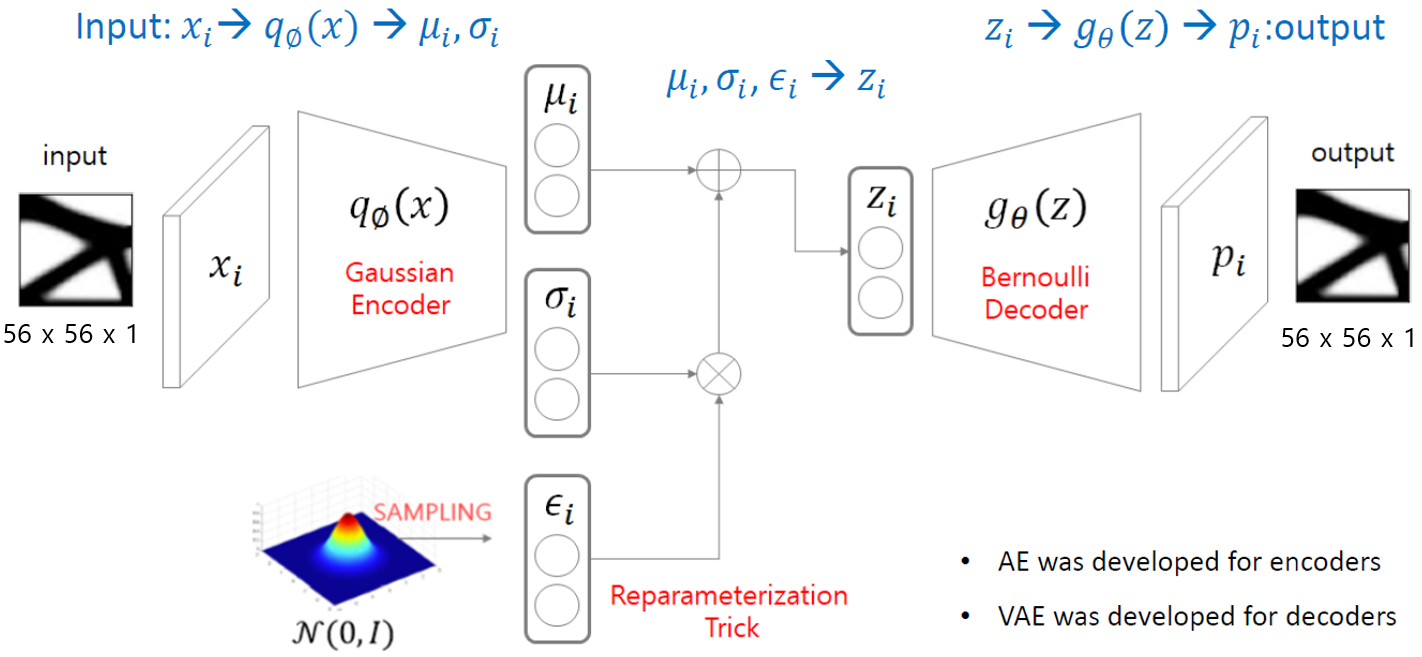

https://taeu.github.io/paper/deeplearning-paper-vae/

In [6]:
# define the Encoder module
class Encoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, intermediate_dim)  # first hidden layer
        self.fc2_mean = nn.Linear(intermediate_dim, latent_dim)  # output for mean
        self.fc2_logvar = nn.Linear(intermediate_dim, latent_dim)  # output for log variance

    def forward(self, x):
        h = torch.relu(self.fc1(x))  # apply ReLU activation to the first layer
        z_mean = self.fc2_mean(h)  # mean of the latent distribution
        z_logvar = self.fc2_logvar(h)  # log variance of the latent distribution

        return z_mean, z_logvar  # return both mean and log variance

In [7]:
# define the Decoder module
class Decoder(nn.Module):
    def __init__(self, latent_dim, intermediate_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, intermediate_dim)  # latent space to hidden layer
        self.fc2 = nn.Linear(intermediate_dim, output_dim)  # hidden layer to output (original image size)

    def forward(self, z):
        h = torch.relu(self.fc1(z))  # apply ReLU activation to the hidden layer
        x_recon = torch.sigmoid(self.fc2(h))  # Sigmoid activation to ensure output is in [0,1] range

        return x_recon  # return the reconstructed image

In [8]:
# define the full Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, intermediate_dim, latent_dim)  # encoder network
        self.decoder = Decoder(latent_dim, intermediate_dim, input_dim)  # decoder network

    # reparameterization trick: sample from the latent distribution
    def reparameterize(self, z_mean, z_logvar):
        epsilon = torch.randn_like(z_mean)  # random noise sampled from a standard normal distribution

        return z_mean + torch.exp(0.5 * z_logvar) * epsilon  # sample z using mean and variance

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)  # get the mean and log variance from encoder
        z = self.reparameterize(z_mean, z_logvar)  # sample z using the reparameterization trick
        x_recon = self.decoder(z)  # reconstruct the input from the sampled z

        return x_recon, z_mean, z_logvar  # return reconstructed image, mean, and log variance

In [9]:
vae = VAE(input_dim, intermediate_dim, latent_dim).to('cuda')

# print the model summary
summary(vae, (input_dim,))  # Replace 'vae' with your model name and 'input_dim' with your input dimension

vae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
            Linear-2                    [-1, 2]           1,026
            Linear-3                    [-1, 2]           1,026
           Encoder-4         [[-1, 2], [-1, 2]]               0
            Linear-5                  [-1, 512]           1,536
            Linear-6                 [-1, 3136]       1,608,768
           Decoder-7                 [-1, 3136]               0
Total params: 3,218,500
Trainable params: 3,218,500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.28
Estimated Total Size (MB): 12.35
----------------------------------------------------------------


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=3136, out_features=512, bias=True)
    (fc2_mean): Linear(in_features=512, out_features=2, bias=True)
    (fc2_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=3136, bias=True)
  )
)

## 6. Train model

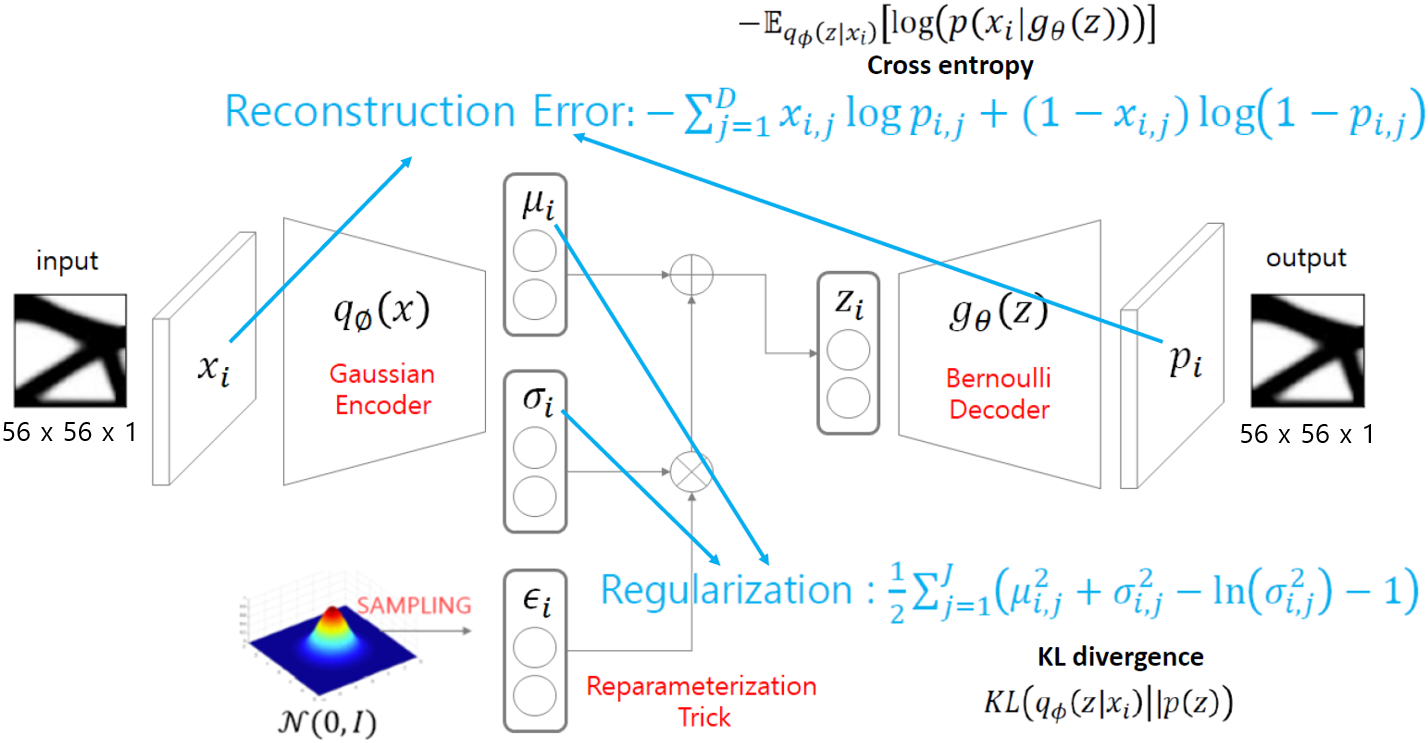

https://taeu.github.io/paper/deeplearning-paper-vae/

In [10]:
# set to loss function & optimizer

# define optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# define the loss function for VAE
def vae_loss(x, x_recon, z_mean, z_logvar):

    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')  # Reconstruction loss (binary cross-entropy)
    kl_loss = 0.5 * torch.sum(z_mean.pow(2) +z_logvar.exp() -z_logvar -1)  # KL Divergence loss

    return recon_loss + kl_loss  # total VAE loss

In [11]:
# convert data to PyTorch tensors
train_images = torch.tensor(x_train, dtype=torch.float32).to('cuda')
train_labels = torch.tensor(y_train, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(x_test, dtype=torch.float32).to('cuda')
test_labels = torch.tensor(y_test, dtype=torch.float32)   # don't need to use labels

# create a DataLoader for the training data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# train the VAE model
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        x_recon, z_mean, z_logvar = vae(x)
        loss = vae_loss(x, x_recon, z_mean, z_logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss_train = total_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train:.4f}")

# save the trained model
torch.save(vae.state_dict(), 'VAE_model.pth')

Epoch [1/100], Train_loss: 27792.0330
Epoch [2/100], Train_loss: 25717.1130
Epoch [3/100], Train_loss: 25208.3824
Epoch [4/100], Train_loss: 25063.4047
Epoch [5/100], Train_loss: 24877.2129
Epoch [6/100], Train_loss: 24785.6581
Epoch [7/100], Train_loss: 24739.5868
Epoch [8/100], Train_loss: 24626.0610
Epoch [9/100], Train_loss: 24633.2225
Epoch [10/100], Train_loss: 24549.5749
Epoch [11/100], Train_loss: 24586.0011
Epoch [12/100], Train_loss: 24486.5641
Epoch [13/100], Train_loss: 24450.9160
Epoch [14/100], Train_loss: 24395.7068
Epoch [15/100], Train_loss: 24380.5193
Epoch [16/100], Train_loss: 24320.0283
Epoch [17/100], Train_loss: 24298.0637
Epoch [18/100], Train_loss: 24258.1719
Epoch [19/100], Train_loss: 24250.3642
Epoch [20/100], Train_loss: 24234.1769
Epoch [21/100], Train_loss: 24191.6728
Epoch [22/100], Train_loss: 24158.4510
Epoch [23/100], Train_loss: 24182.5006
Epoch [24/100], Train_loss: 24109.4423
Epoch [25/100], Train_loss: 24060.1853
Epoch [26/100], Train_loss: 24021.

## 7. Load & Evaluate model

- Compare the orginial image and the reconstructed image

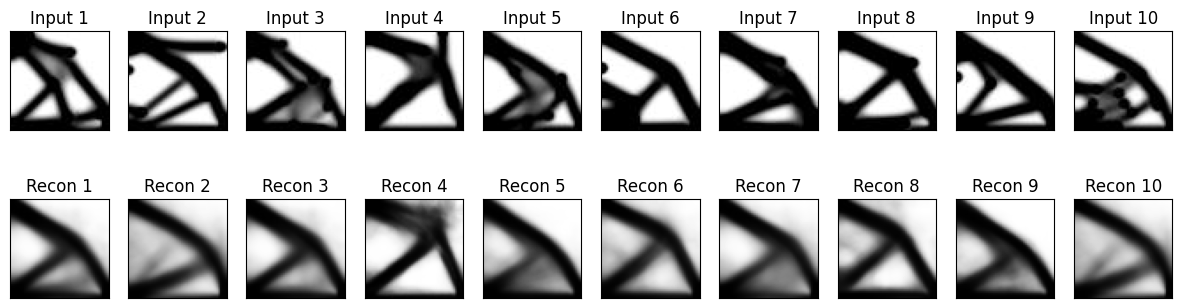

In [13]:
# set the model to evaluation mode (no gradients will be computed)
vae.eval()

# reconstruct the test images using the trained VAE
with torch.no_grad():
    recon_x_test, _, _ = vae(test_images)

# visualize the original and reconstructed images

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title(f"Input {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title(f"Recon {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

- Plot latent space (2D) manifold

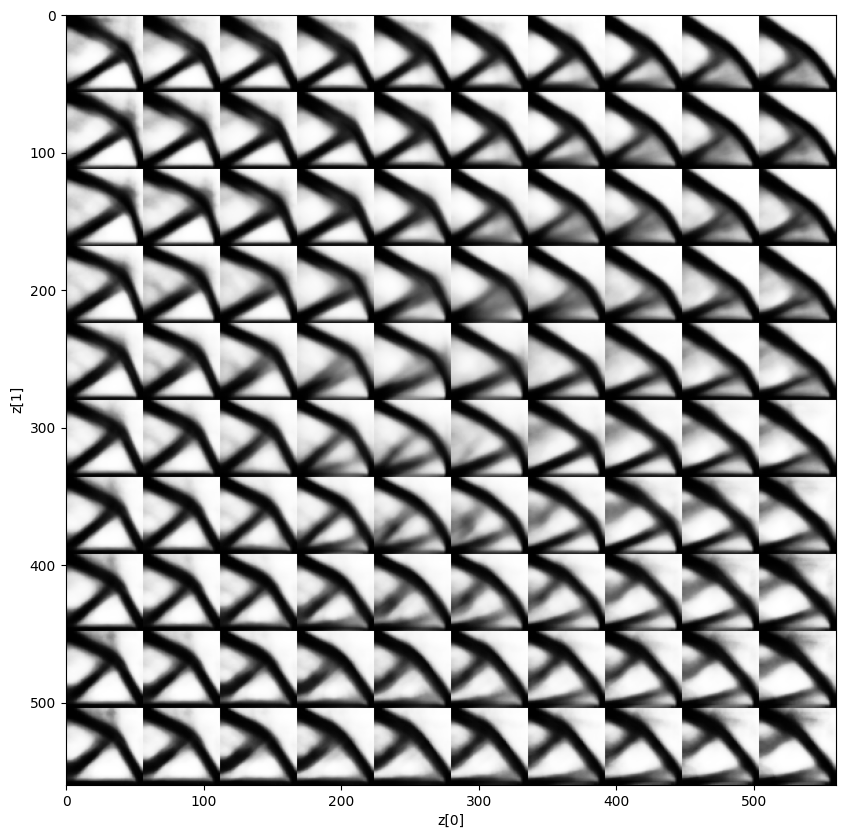

In [14]:
# function to visualize the latent space manifold
def plot_latent_space(vae, n=10, digit_size=56):

    # create an empty array to hold the grid of images
    figure = np.zeros((digit_size * n, digit_size * n))

    # generate linear spaces for the x and y axes (latent dimensions)
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    # loop over the grid coordinates and decode latent points to images
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            # sample a point (xi, yi) from the latent space and convert to a tensor
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to('cuda')

            # use the decoder to generate an image from the latent vector z_sample
            x_decoded = vae.decoder(z_sample).cpu().detach().numpy()

            # reshape the output to the digit size (56x56)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # place the generated image into the figure grid at position (i, j)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # plot the grid of generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_latent_space(vae)  # call the function to plot the latent space manifold

- Visualize latent space using t-SNE

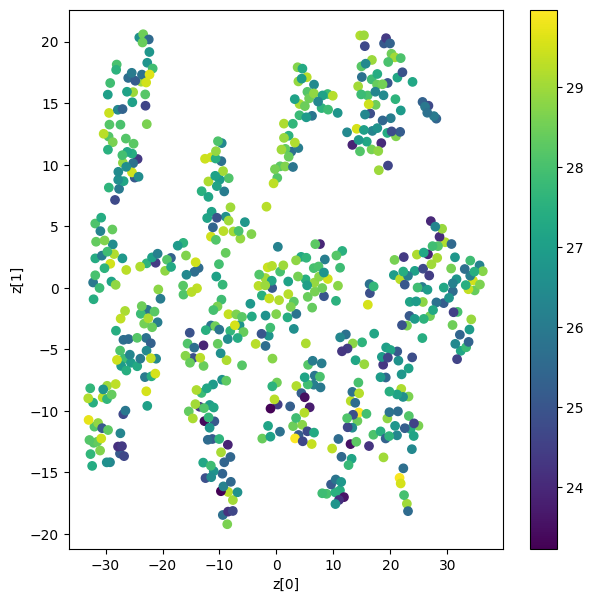

In [15]:
# set the model to evaluation mode (no gradients will be computed)
vae.eval()

with torch.no_grad():  # disable gradient computation since we're only doing inference
    z_mean, z_logvar = vae.encoder(test_images)  # get the latent vectors (z_mean) and z_logvar for the test images

# convert the latent vectors from PyTorch tensors to NumPy arrays for t-SNE
z_mean_np = z_mean.cpu().detach().numpy()

# apply t-SNE to reduce the latent space to 2 dimensions for visualization
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean_np)

# create a scatter plot of the t-SNE results
plt.figure(figsize=(7, 7))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

## 8. Linear interpolation between two points in the latent space

In [16]:
# function for linear interpolation between two points in the latent space
def linear_interpolation(x_from, x_to, steps=10):
    """
    Performs linear interpolation between two points in latent space.

    Args:
    - x_from: Starting latent vector (latent dimension).
    - x_to: Ending latent vector (latent dimension).
    - steps: Number of interpolation steps (default is 10).

    Returns:
    - inter: Interpolated latent vectors between x_from and x_to.
    """
    n = steps + 1  # number of interpolation points (including start and end)

    t_from = x_from  # starting point in the latent space
    t_to = x_to  # ending point in the latent space

    # compute the difference between the two latent vectors
    diff = t_to - t_from

    # initialize an array to store the interpolated vectors
    inter = np.zeros((n, t_from.shape[0]))

    # perform the linear interpolation
    for i in range(n):
        inter[i] = t_from + (i / steps) * diff  # linearly interpolate between the two vectors

    return inter  # return the interpolated vectors

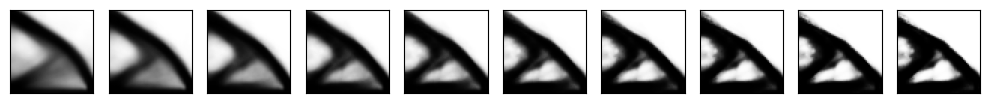

In [17]:
# define the start and end points in the latent space
target_a = np.array([1, 1])  # start coordinate in the latent space
target_b = np.array([10, 10])  # end coordinate in the latent space

# perform linear interpolation between the two latent points
interpolated_latent_vectors = linear_interpolation(target_a, target_b, steps=10)

# convert the interpolated latent vectors to PyTorch tensors
interpolated_latent_vectors = torch.tensor(interpolated_latent_vectors, dtype=torch.float32).to('cuda')

# use the VAE's decoder to generate images from the interpolated latent vectors
with torch.no_grad():
    z_decoder_imgs = vae.decoder(interpolated_latent_vectors).cpu().detach().numpy()

# visualization of the decoded images generated from the interpolated latent vectors
N = 1  # number of rows of images to display
M = 10  # number of images to display in each row (same as steps + 1)
img_size = 56  # image size (assuming 56x56)

# create a figure to display the images
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)

# plot the interpolated images
for i in range(N):
    for j in range(M):

        k = i * M + j  # calculate index
        ax = fig.add_subplot(N, M, k+1)

        # reshape and display the image
        ax.imshow(np.reshape(z_decoder_imgs[k], (img_size, img_size)), cmap=plt.cm.gist_gray)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

plt.tight_layout()
plt.show()